In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json 
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
import glob         
import sys
import numpy as np 
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore") 
import mymodule
from mymodule import BatchGenerator
from mymodule import Make_Raw_List2
from mymodule import plot_loss_accuracy_graph
import shutil
import os

In [3]:
import pandas as pd
df=pd.read_csv('data.csv')
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0


In [4]:
#1: healthy, 0:abnormal
def health(x):
    if x!=0:
        a=0
    else:
        a=1
    return a

def unhealth(x):
    if x!=0:
        a=1
    else:
        a=0
    return a

In [5]:
df['HE_on']=df['AMD']+df['RVO']+df['Gla']+df['MH']+df['DR']+df['RD']+df['RP']+df['AO']+df['DM']
df['HE']=df['HE_on'].apply(lambda x: health(x))
# df['unHE']=df['HE_on'].apply(lambda x: unhealth(x))
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0,0,1
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0,0,1
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0,0,1
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0,0,1
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0,0,1
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0,0,1
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0,0,1
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0,0,1


In [6]:
root=os.getcwd()
root

'/Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master'

In [29]:
#create folders
class_name=['AMD','RVO','Gla','MH','DR','RD','RP','AO','DM','HE']
for pathy in class_name:
    os.makedirs(root+'/cate/train/'+pathy)
    os.makedirs(root+'/cate/test/'+pathy)

In [30]:
# classify the images into different folders based on the diseases they belong to 
for pathy in class_name:
    df_tem=df.loc[df[pathy]==1]
    df_tem = df_tem.sample(frac = 1)
    n_train=int(len(df_tem)*0.8)
    for i in range(len(df_tem)):
        img=df_tem.iloc[i,0]
        if i<=n_train:
            shutil.copy(root+'/img/'+img, root+'/cate/train/'+pathy)
        else:
            shutil.copy(root+'/img/'+img, root+'/cate/test/'+pathy)

In [7]:
#load the training data
img_height=256
img_width=256
batch_size=16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate_3/test',
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2059 files belonging to 3 classes.
Using 1545 files for training.


2022-12-14 01:44:34.262364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#load the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate_3/test',
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2059 files belonging to 3 classes.
Using 514 files for validation.


In [9]:
#load the test data
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate_3/test',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 2059 files belonging to 3 classes.


In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

In [11]:
#build the Inception V3 model
model_i = InceptionV3(include_top=False, input_shape=(img_height, img_width, 3))
flat1 = Flatten()(model_i.output)
class1 = Dense(64, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
model_i = Model(inputs=model_i.inputs, outputs=output)
model_i.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
#train the model
model_i.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history_i = model_i.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
97/97 [==============================] - 348s 4s/step - loss: 1.2184 - accuracy: 0.4822 - val_loss: 1.0458 - val_accuracy: 0.4261
Epoch 2/5
97/97 [==============================] - 284s 3s/step - loss: 0.8801 - accuracy: 0.6052 - val_loss: 0.8821 - val_accuracy: 0.5914
Epoch 3/5
97/97 [==============================] - 289s 3s/step - loss: 0.7229 - accuracy: 0.6932 - val_loss: 0.9084 - val_accuracy: 0.5973
Epoch 4/5
97/97 [==============================] - 295s 3s/step - loss: 0.5883 - accuracy: 0.7592 - val_loss: 0.9117 - val_accuracy: 0.6323
Epoch 5/5
97/97 [==============================] - 308s 3s/step - loss: 0.4750 - accuracy: 0.8149 - val_loss: 1.0909 - val_accuracy: 0.5681


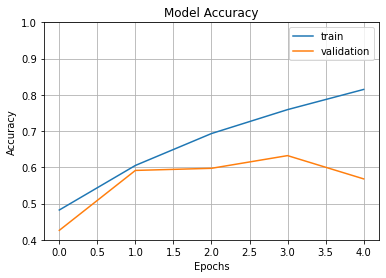

In [14]:
# plot the trend of training and validation accuracy
fig1 = plt.gcf()
plt.plot(history_i.history['accuracy'])
plt.plot(history_i.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
#save the model
model_i.save('best_model_path_3_IV3.h5')

In [20]:
import pandas as pd

In [ ]:
#load the saved trained the model
test_model = keras.models.load_model('best_model_path_3_IV3.h5')

In [53]:
#predict the test data
df_p=pd.DataFrame(test_model.predict(test_ds))
df_p

129/129 [==============================] - 78s 605ms/step


,0,1,2
0,0.999887,0.000107,0.000005
1,0.236982,0.298799,0.464219
2,0.622748,0.308484,0.068768
3,0.986848,0.011970,0.001182
4,0.831820,0.080710,0.087470
...,...,...,...
2054,0.295015,0.548553,0.156432
2055,0.195366,0.259310,0.545324
2056,0.122436,0.051116,0.826448
2057,0.826097,0.076505,0.097398


In [54]:
#add the original label as the last column in the dataframe
test_label = np.concatenate([y for x, y in test_ds], axis=0) 
df_l=pd.DataFrame(test_label)
df_l
pd.concat([df_p,df_l],axis=1)

,0,1,2,0
0,0.999887,0.000107,0.000005,0
1,0.236982,0.298799,0.464219,0
2,0.622748,0.308484,0.068768,0
3,0.986848,0.011970,0.001182,0
4,0.831820,0.080710,0.087470,0
...,...,...,...,...
2054,0.295015,0.548553,0.156432,2
2055,0.195366,0.259310,0.545324,2
2056,0.122436,0.051116,0.826448,2
2057,0.826097,0.076505,0.097398,2


In [37]:
#evaluate the model
test_model.evaluate(test_ds)

129/129 [==============================] - 78s 603ms/step - loss: 1.2137 - accuracy: 0.4939


[1.213718056678772, 0.49392908811569214]